<a href="https://colab.research.google.com/github/annaju1ia/MRI-Axial-Detection/blob/main/Pront%C3%ADssimoMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Verifica se há uma GPU disponível e lista informações sobre ela, como modelo, memória e uso.
!nvidia-smi


/bin/bash: line 1: nvidia-smi: command not found


In [2]:
# Importa o módulo 'os' para interagir com o sistema operacional.
# Define a variável HOME como o diretório atual de trabalho.
# Imprime o diretório atual, permitindo confirmar onde os arquivos serão manipulados ou salvos.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import yaml
from pathlib import Path
import random
from collections import Counter, defaultdict
import glob
from IPython.display import display, Image as IPImage

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("husl")

HOME = os.getcwd()
print(HOME)


/content


In [3]:
!pip install ultralytics==8.2.103 -q



from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()
from ultralytics import YOLO



Ultralytics YOLOv8.2.103 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 40.3/107.7 GB disk)


In [4]:
# Cria um diretório 'datasets' no diretório atual (HOME) se ele ainda não existir, para armazenar os dados do projeto.
# A opção '-p' permite criar o diretório pai, caso necessário.
!mkdir -p {HOME}/datasets

# Altera o diretório atual de trabalho para o novo diretório 'datasets'.
%cd {HOME}/datasets

# Instala o pacote 'roboflow', que facilita o acesso a datasets e modelos treinados, além de permitir o download de dados.
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="YKGaAiWa9Jw92WpzyZl8")
project = rf.workspace("roboflow-100").project("axial-mri")
version = project.version(2)
dataset = version.download("yolov8")
%cd {HOME}




/content/datasets
loading Roboflow workspace...
loading Roboflow project...
/content


In [5]:
# Baixa o dataset no formato compatível com YOLOv8.
dataset = version.download("yolov8")

🚀 EXECUTANDO ANÁLISE EDA - SPLITS REAIS
🎯 SPLITS DISPONÍVEIS: ['train', 'val', 'valid', 'test']
📊 GERANDO RELATÓRIO DE EDA COMPLETO
🎯 ANALISANDO SPLITS DISPONÍVEIS: ['train', 'val', 'valid', 'test']
🔍 VALIDANDO INTEGRIDADE DO DATASET
  TRAIN:
    • Imagens: 253
    • Labels: 253
    • Imagens sem labels: 0
    • Labels sem imagens: 0
  VAL:
    • Imagens: 0
    • Labels: 0
    • Imagens sem labels: 0
    • Labels sem imagens: 0
  VALID:
    • Imagens: 79
    • Labels: 79
    • Imagens sem labels: 0
    • Labels sem imagens: 0
  TEST:
    • Imagens: 39
    • Labels: 39
    • Imagens sem labels: 0
    • Labels sem imagens: 0

📊 TOTAIS:
  • Imagens: 371
  • Labels: 371

✅ Dataset validado com sucesso!

📈 ANALISANDO DISTRIBUIÇÃO DOS SPLITS EXISTENTES...
  TRAIN: 253 imagens, 253 labels, 258 bboxes
  VAL: 0 imagens, 0 labels, 0 bboxes
  VALID: 79 imagens, 79 labels, 85 bboxes
  TEST: 39 imagens, 39 labels, 47 bboxes

🖼️ ANALISANDO CARACTERÍSTICAS DOS SPLITS EXISTENTES...

🔍 ANALISANDO SPLIT

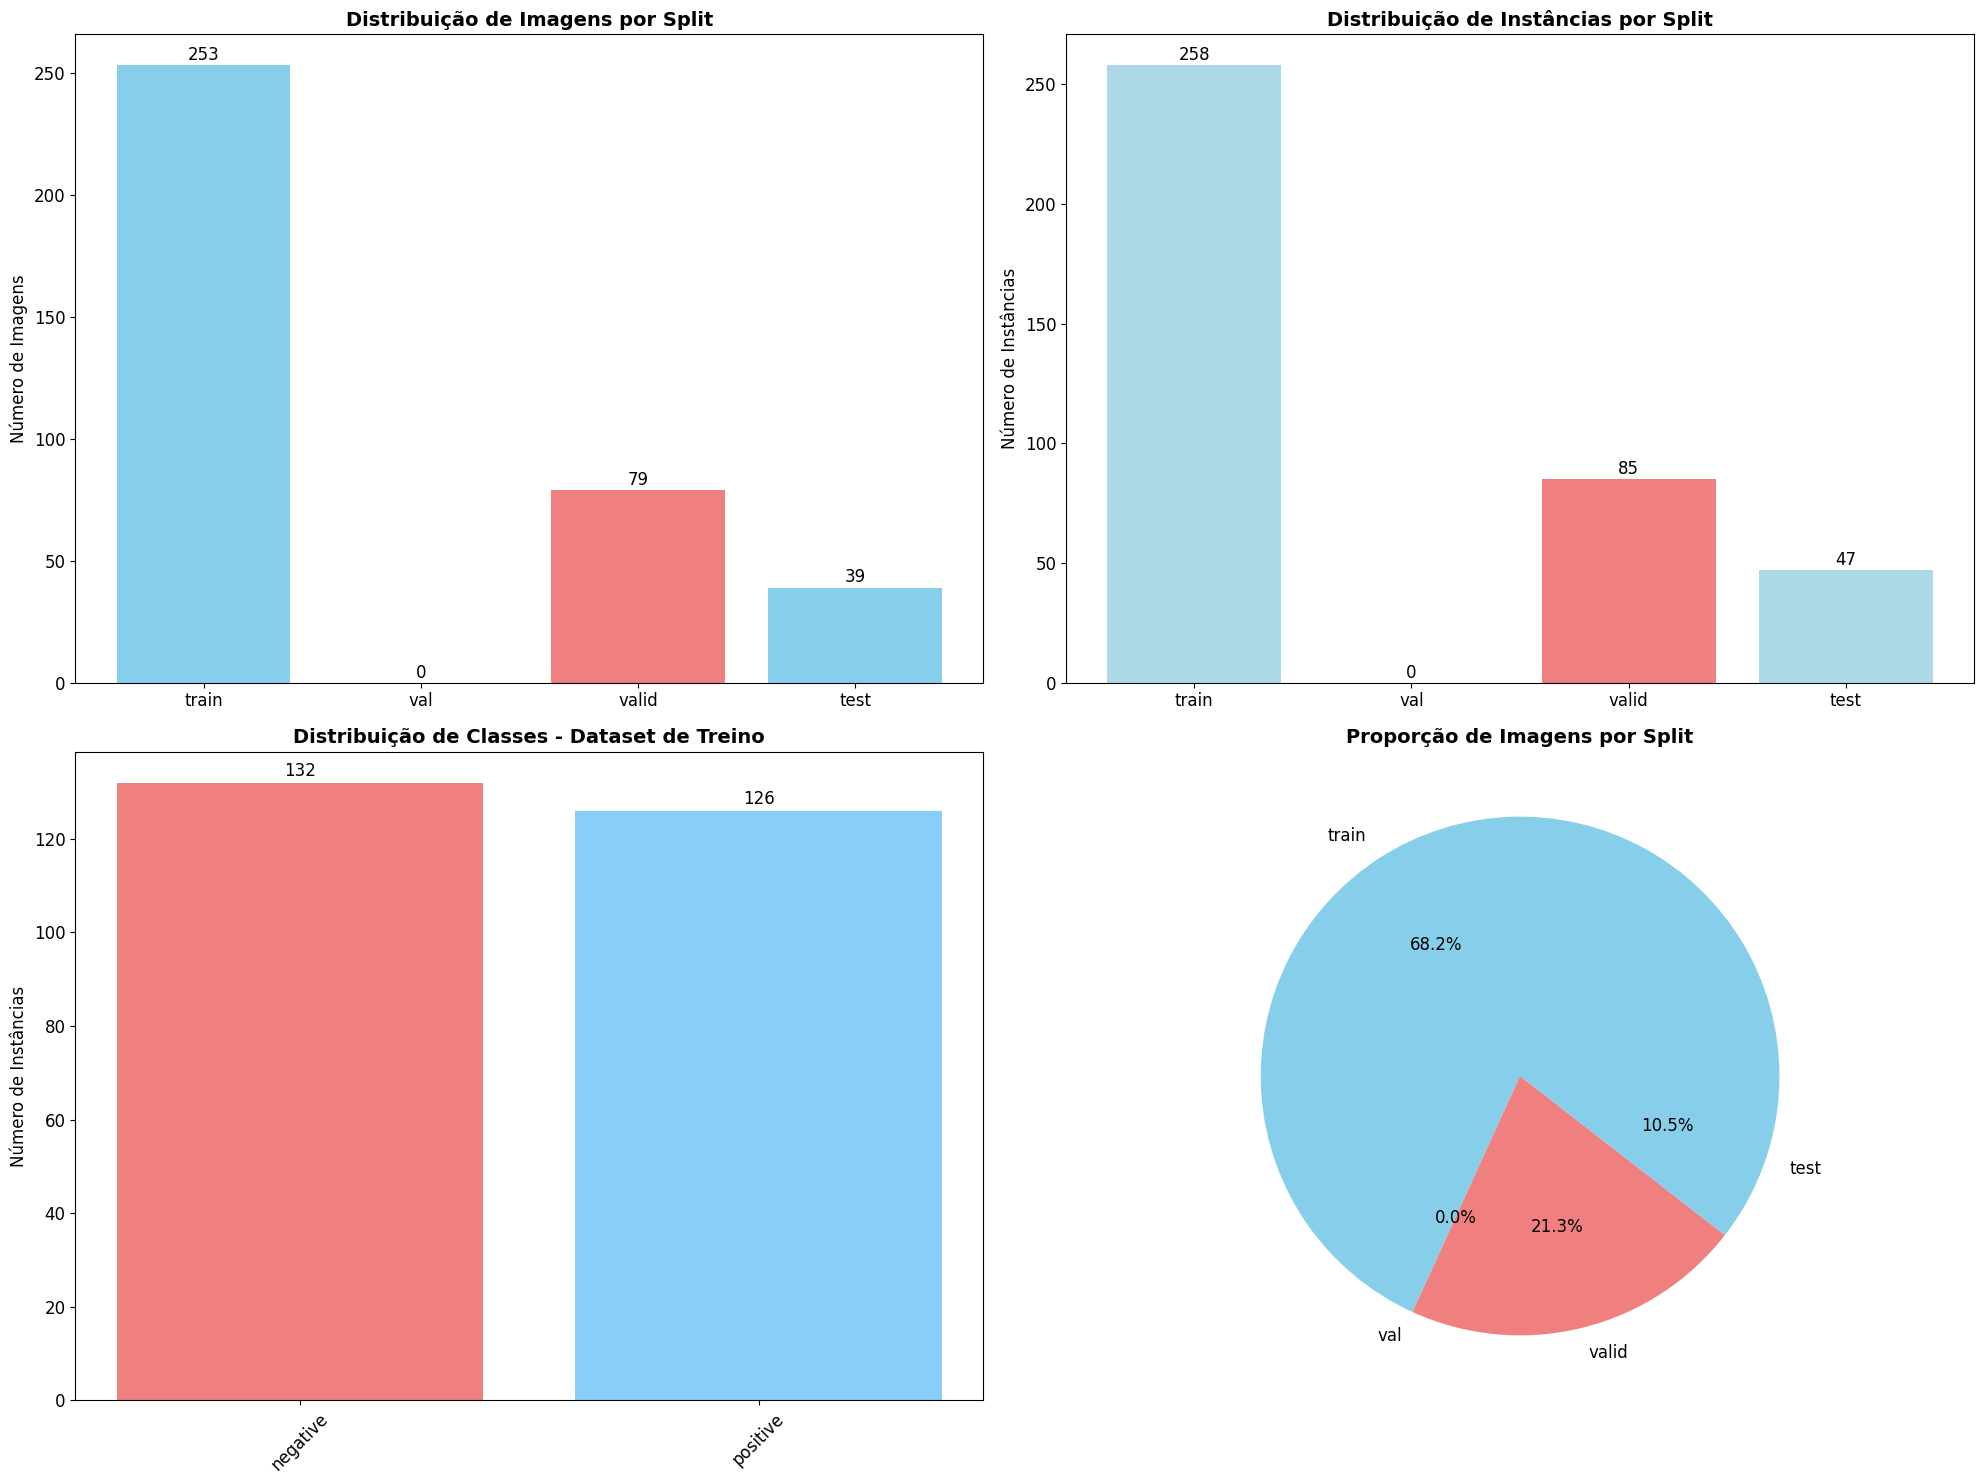

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.


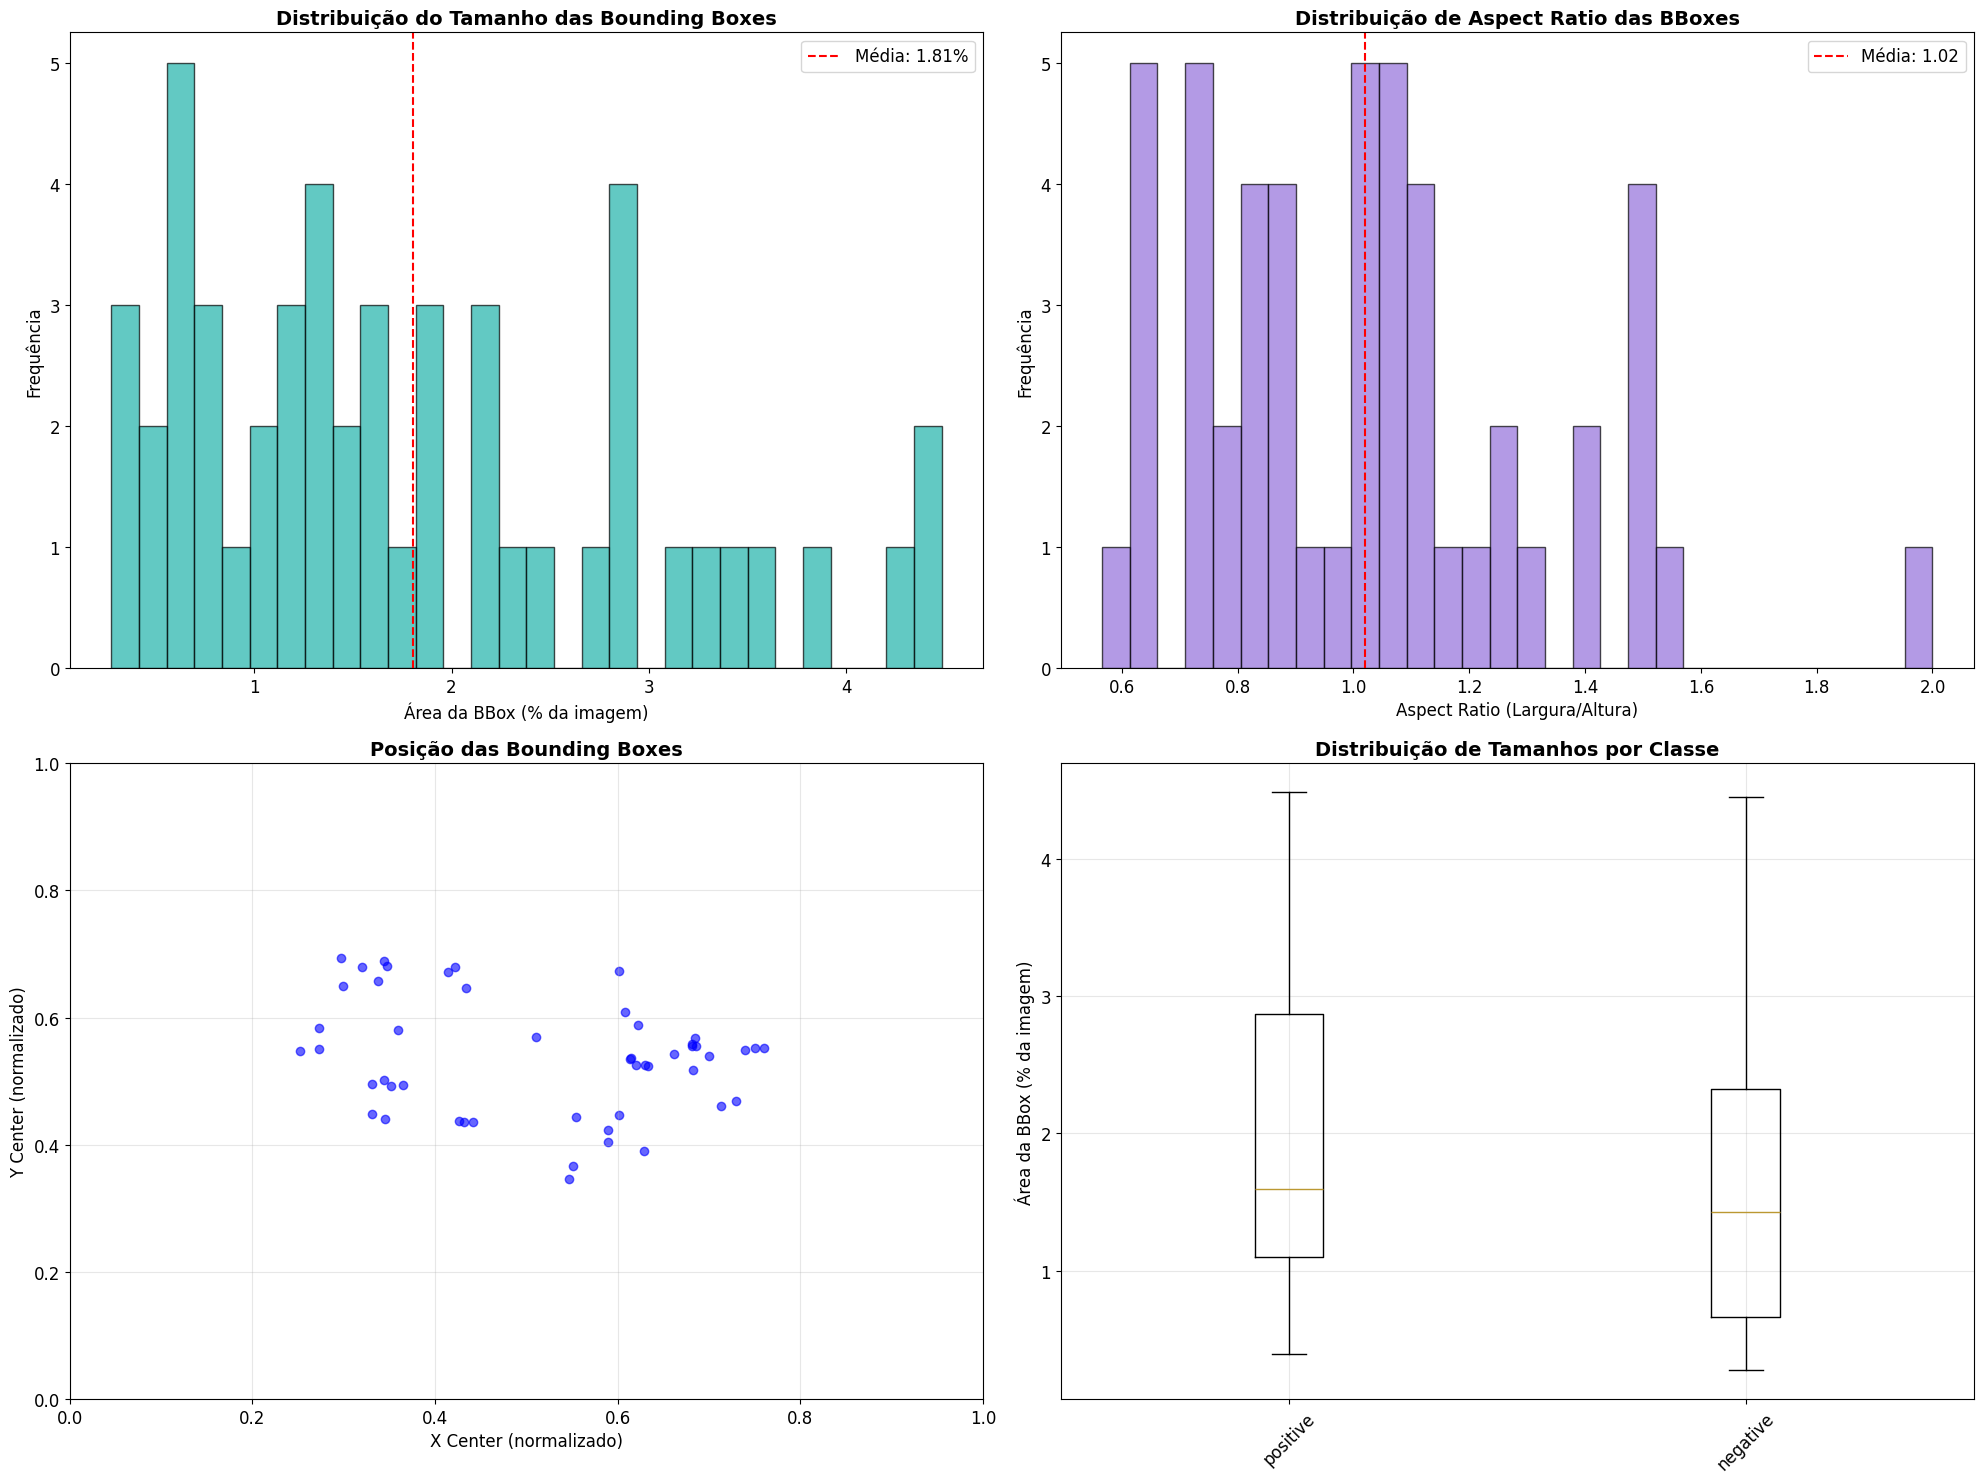

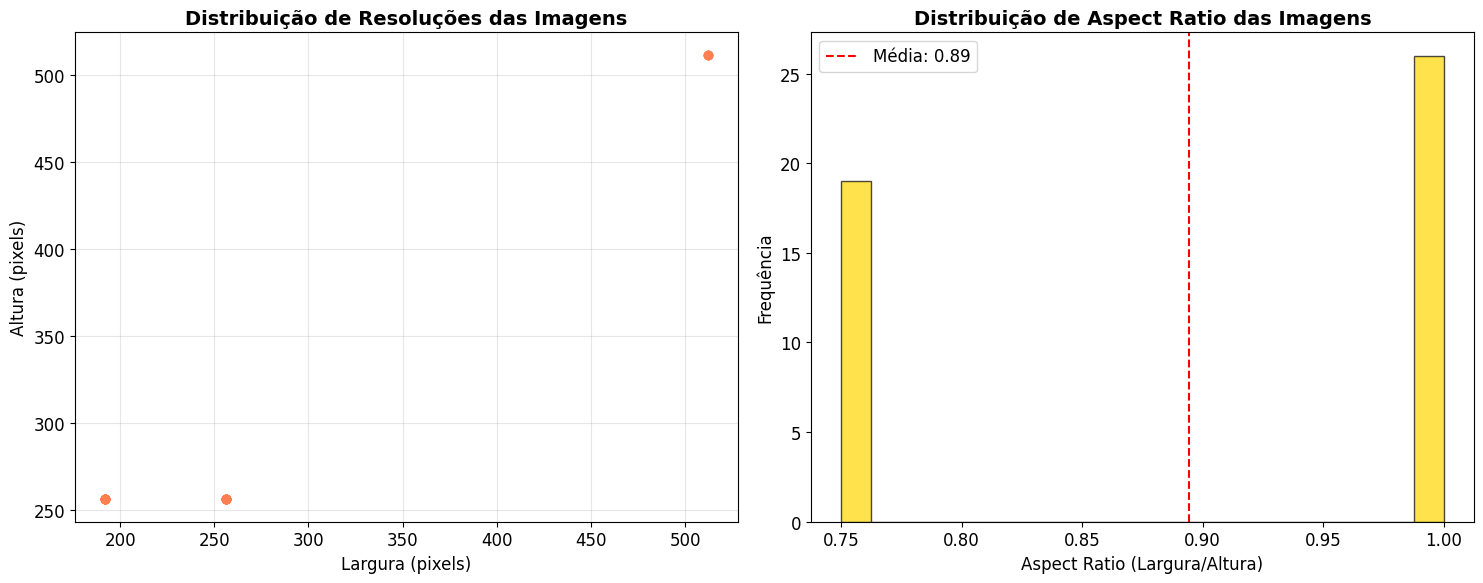

In [6]:

# CLASE MRIDatasetAnalyzer CORRIGIDA


class MRIDatasetAnalyzer:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.data_yaml = self.dataset_path / 'data.yaml'

        # Carregar configurações do dataset
        with open(self.data_yaml, 'r') as f:
            self.config = yaml.safe_load(f)

        self.class_names = self.config['names']
        self.num_classes = len(self.class_names)

        # Descobrir automaticamente quais splits existem
        self.available_splits = self._discover_available_splits()

    def _discover_available_splits(self):
        """Descobre automaticamente quais splits existem no dataset"""
        possible_splits = ['train', 'training', 'val', 'validation', 'valid', 'test', 'testing']
        available = []

        for split in possible_splits:
            split_path = self.dataset_path / split
            if split_path.exists():
                available.append(split)

        print(f"SPLITS DISPONÍVEIS: {available}")
        return available

    def analyze_dataset_distribution(self):
        """Analisa distribuição do dataset entre splits EXISTENTES"""
        stats = {}

        for split in self.available_splits:
            labels_path = self.dataset_path / split / 'labels'
            images_path = self.dataset_path / split / 'images'

            # CONTAGEM CORRIGIDA: Buscar TODOS os tipos de imagem
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp', '*.JPG', '*.JPEG', '*.PNG']
            image_files = []
            for ext in image_extensions:
                image_files.extend(images_path.glob(ext))

            # Contar labels
            label_files = list(labels_path.glob('*.txt'))

            # Contar instâncias por classe
            class_counts = Counter()
            total_bboxes = 0

            for label_file in label_files:
                try:
                    with open(label_file, 'r') as f:
                        for line in f:
                            parts = line.strip().split()
                            if len(parts) >= 5:
                                class_id = int(parts[0])
                                class_counts[class_id] += 1
                                total_bboxes += 1
                except Exception as e:
                    print(f"⚠️  Erro ao ler arquivo {label_file}: {e}")

            stats[split] = {
                'images': len(image_files),
                'labels': len(label_files),
                'instances': total_bboxes,
                'class_distribution': dict(class_counts)
            }

            print(f"  {split.upper()}: {len(image_files)} imagens, {len(label_files)} labels, {total_bboxes} bboxes")

        return stats

    def analyze_all_splits_characteristics(self, sample_size_per_split=10):
        """Analisa características de TODOS os splits DISPONÍVEIS"""
        all_image_sizes = []
        all_bbox_stats = []
        all_aspect_ratios = []

        for split in self.available_splits:
            print(f"\n🔍 ANALISANDO SPLIT: {split.upper()}")
            image_sizes, bbox_stats, aspect_ratios = self.analyze_image_characteristics(split, sample_size_per_split)

            all_image_sizes.extend(image_sizes)
            all_bbox_stats.extend(bbox_stats)
            all_aspect_ratios.extend(aspect_ratios)

            print(f"✅ {split.upper()}: {len(image_sizes)} imagens, {len(bbox_stats)} bboxes")

        return all_image_sizes, all_bbox_stats, all_aspect_ratios

    def analyze_image_characteristics(self, split='train', sample_size=20):
        """Analisa características das imagens e bounding boxes"""
        images_path = self.dataset_path / split / 'images'
        labels_path = self.dataset_path / split / 'labels'

        if not images_path.exists():
            print(f"❌ Pasta de imagens não encontrada: {images_path}")
            return [], [], []

        # BUSCAR TODOS OS TIPOS DE IMAGEM
        image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
        all_image_files = []
        for ext in image_extensions:
            all_image_files.extend(images_path.glob(ext))

        print(f"📁 {split.upper()}: Encontradas {len(all_image_files)} imagens no total")

        # Amostrar imagens
        image_files = all_image_files[:sample_size]

        image_sizes = []
        bbox_stats = []
        aspect_ratios = []

        print(f"🔍 Analisando {len(image_files)} imagens do split {split}...")

        for img_path in image_files:
            img = cv2.imread(str(img_path))
            if img is not None:
                height, width, channels = img.shape
                image_sizes.append((width, height))
                aspect_ratios.append(width / height)

                # Ler bounding boxes correspondentes
                label_path = labels_path / img_path.with_suffix('.txt').name
                if label_path.exists():
                    try:
                        with open(label_path, 'r') as f:
                            for line in f:
                                parts = line.strip().split()
                                if len(parts) >= 5:
                                    class_id, x_center, y_center, bbox_width, bbox_height = map(float, parts[:5])

                                    bbox_width_px = bbox_width * width
                                    bbox_height_px = bbox_height * height
                                    bbox_area_ratio = bbox_width * bbox_height

                                    bbox_stats.append({
                                        'class_id': int(class_id),
                                        'class_name': self.class_names[int(class_id)],
                                        'width_pixels': bbox_width_px,
                                        'height_pixels': bbox_height_px,
                                        'area_ratio': bbox_area_ratio,
                                        'aspect_ratio': bbox_width_px / bbox_height_px if bbox_height_px > 0 else 0,
                                        'x_center': x_center,
                                        'y_center': y_center,
                                        'image_width': width,
                                        'image_height': height,
                                        'split': split
                                    })
                    except Exception as e:
                        print(f"⚠️  Erro ao processar label {label_path}: {e}")
            else:
                print(f"⚠️  Não foi possível carregar a imagem: {img_path}")

        print(f"✅ {split.upper()}: {len(image_sizes)} imagens processadas, {len(bbox_stats)} bboxes encontradas")
        return image_sizes, bbox_stats, aspect_ratios

    def validate_dataset_integrity(self):
        """Valida a integridade do dataset - APENAS SPLITS EXISTENTES"""
        print("🔍 VALIDANDO INTEGRIDADE DO DATASET")
        print("=" * 50)

        issues = []
        total_images = 0
        total_labels = 0

        for split in self.available_splits:
            images_path = self.dataset_path / split / 'images'
            labels_path = self.dataset_path / split / 'labels'

            if not images_path.exists():
                issues.append(f"Pasta de imagens não encontrada: {images_path}")
                continue
            if not labels_path.exists():
                issues.append(f"Pasta de labels não encontrada: {labels_path}")
                continue

            # Buscar todas as imagens
            image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
            image_files = set()
            for ext in image_extensions:
                for img_path in images_path.glob(ext):
                    image_files.add(img_path.stem)

            # Buscar todos os labels
            label_files = set([f.stem for f in labels_path.glob('*.txt')])

            missing_labels = image_files - label_files
            missing_images = label_files - image_files

            total_images += len(image_files)
            total_labels += len(label_files)

            if missing_labels:
                issues.append(f"{split}: {len(missing_labels)} imagens sem labels")
            if missing_images:
                issues.append(f"{split}: {len(missing_images)} labels sem imagens")

            print(f"  {split.upper()}:")
            print(f"    • Imagens: {len(image_files)}")
            print(f"    • Labels: {len(label_files)}")
            print(f"    • Imagens sem labels: {len(missing_labels)}")
            print(f"    • Labels sem imagens: {len(missing_images)}")

        print(f"\nTOTAIS:")
        print(f"  • Imagens: {total_images}")
        print(f"  • Labels: {total_labels}")

        if issues:
            print(f"\n❌ PROBLEMAS ENCONTRADOS ({len(issues)}):")
            for issue in issues:
                print(f"  - {issue}")
            return False
        else:
            print(f"\n✅ Dataset validado com sucesso!")
            return True

    def generate_eda_report(self):
        """Gera relatório completo de EDA - USANDO SPLITS REAIS"""
        print("📊 GERANDO RELATÓRIO DE EDA COMPLETO")
        print("=" * 60)
        print(f"ANALISANDO SPLITS DISPONÍVEIS: {self.available_splits}")

        # Validar integridade primeiro
        is_valid = self.validate_dataset_integrity()

        if not is_valid:
            print("⚠️  Problemas no dataset detectados. Continuando análise...")

        # Análise de distribuição
        print("\nANALISANDO DISTRIBUIÇÃO DOS SPLITS EXISTENTES...")
        dataset_stats = self.analyze_dataset_distribution()

        # Análise de características
        print("\nANALISANDO CARACTERÍSTICAS DOS SPLITS EXISTENTES...")
        image_sizes, bbox_stats, aspect_ratios = self.analyze_all_splits_characteristics(15)

        # Criar DataFrames para análise
        bbox_df = pd.DataFrame(bbox_stats) if bbox_stats else pd.DataFrame()

        # Calcular totais
        total_images = sum([stats['images'] for stats in dataset_stats.values()])
        total_instances = sum([stats['instances'] for stats in dataset_stats.values()])

        print(f"\nRESUMO FINAL - DATASET REAL:")
        print(f"  • Total de imagens: {total_images}")
        print(f"  • Total de instâncias/bboxes: {total_instances}")
        print(f"  • Distribuição por split:")
        for split in self.available_splits:
            stats = dataset_stats[split]
            print(f"    - {split}: {stats['images']} imagens, {stats['instances']} bboxes")
        print(f"  • Número de classes: {self.num_classes}")
        print(f"  • Classes: {self.class_names}")

        return dataset_stats, bbox_df, image_sizes, aspect_ratios

# Executar análise EDA CORRIGIDA
print("EXECUTANDO ANÁLISE EDA - SPLITS REAIS")
print("=" * 60)

analyzer = MRIDatasetAnalyzer(f"{HOME}/datasets/axial-MRI-2")
dataset_stats, bbox_df, image_sizes, aspect_ratios = analyzer.generate_eda_report()
def create_eda_visualizations(dataset_stats, bbox_df, class_names, image_sizes, aspect_ratios):
    """Cria visualizações completas do EDA"""

    print("CRIANDO VISUALIZAÇÕES DO EDA")

    # 1. Distribuição do Dataset
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

    # Distribuição de imagens por split
    split_names = list(dataset_stats.keys())
    image_counts = [dataset_stats[split]['images'] for split in split_names]
    ax1.bar(split_names, image_counts, color=['skyblue', 'lightgreen', 'lightcoral'])
    ax1.set_title('Distribuição de Imagens por Split', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Número de Imagens')
    for i, v in enumerate(image_counts):
        ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')

    # Distribuição de instâncias por split
    instance_counts = [dataset_stats[split]['instances'] for split in split_names]
    ax2.bar(split_names, instance_counts, color=['lightblue', 'lightgreen', 'lightcoral'])
    ax2.set_title('Distribuição de Instâncias por Split', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Número de Instâncias')
    for i, v in enumerate(instance_counts):
        ax2.text(i, v + 0.5, str(v), ha='center', va='bottom')

    # Distribuição de classes no treino
    if dataset_stats['train']['class_distribution']:
        train_classes = dataset_stats['train']['class_distribution']
        class_ids = list(train_classes.keys())
        class_counts = [train_classes[class_id] for class_id in class_ids]
        class_labels = [class_names[class_id] for class_id in class_ids]

        colors = ['lightcoral', 'lightskyblue']
        ax3.bar(class_labels, class_counts, color=colors[:len(class_labels)])
        ax3.set_title('Distribuição de Classes - Dataset de Treino', fontsize=14, fontweight='bold')
        ax3.set_ylabel('Número de Instâncias')
        ax3.tick_params(axis='x', rotation=45)

        for i, v in enumerate(class_counts):
            ax3.text(i, v + 0.5, str(v), ha='center', va='bottom')

    # Proporções entre splits
    total_images = sum(image_counts)
    split_percentages = [(count/total_images)*100 for count in image_counts]
    ax4.pie(split_percentages, labels=split_names, autopct='%1.1f%%',
            colors=['skyblue', 'lightgreen', 'lightcoral'])
    ax4.set_title('Proporção de Imagens por Split', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # 2. Análise de Bounding Boxes (se disponível)
    if not bbox_df.empty:
        fig, ((ax5, ax6), (ax7, ax8)) = plt.subplots(2, 2, figsize=(20, 15))

        # Distribuição de áreas das bounding boxes
        bbox_areas = bbox_df['area_ratio'] * 100  # Converter para porcentagem
        ax5.hist(bbox_areas, bins=30, edgecolor='black', alpha=0.7, color='lightseagreen')
        ax5.set_title('Distribuição do Tamanho das Bounding Boxes', fontsize=14, fontweight='bold')
        ax5.set_xlabel('Área da BBox (% da imagem)')
        ax5.set_ylabel('Frequência')
        ax5.axvline(bbox_areas.mean(), color='red', linestyle='--', label=f'Média: {bbox_areas.mean():.2f}%')
        ax5.legend()

        # Distribuição de aspect ratios
        bbox_aspect_ratios = bbox_df['aspect_ratio']
        ax6.hist(bbox_aspect_ratios, bins=30, edgecolor='black', alpha=0.7, color='mediumpurple')
        ax6.set_title('Distribuição de Aspect Ratio das BBoxes', fontsize=14, fontweight='bold')
        ax6.set_xlabel('Aspect Ratio (Largura/Altura)')
        ax6.set_ylabel('Frequência')
        ax6.axvline(bbox_aspect_ratios.mean(), color='red', linestyle='--', label=f'Média: {bbox_aspect_ratios.mean():.2f}')
        ax6.legend()

        # Posição das bounding boxes
        if 'x_center' in bbox_df.columns and 'y_center' in bbox_df.columns:
            ax7.scatter(bbox_df['x_center'], bbox_df['y_center'], alpha=0.6, c='blue')
            ax7.set_xlabel('X Center (normalizado)')
            ax7.set_ylabel('Y Center (normalizado)')
            ax7.set_title('Posição das Bounding Boxes', fontsize=14, fontweight='bold')
            ax7.set_xlim(0, 1)
            ax7.set_ylim(0, 1)
            ax7.grid(True, alpha=0.3)

        # Boxplot de áreas por classe
        if 'class_name' in bbox_df.columns:
            class_area_data = []
            class_labels = []
            for class_name in bbox_df['class_name'].unique():
                class_data = bbox_df[bbox_df['class_name'] == class_name]['area_ratio'] * 100
                class_area_data.append(class_data)
                class_labels.append(class_name)

            ax8.boxplot(class_area_data, labels=class_labels)
            ax8.set_xticklabels(class_labels, rotation=45)
            ax8.set_ylabel('Área da BBox (% da imagem)')
            ax8.set_title('Distribuição de Tamanhos por Classe', fontsize=14, fontweight='bold')
            ax8.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    # 3. Análise de Características das Imagens
    if image_sizes:
        fig, (ax9, ax10) = plt.subplots(1, 2, figsize=(15, 6))

        # Distribuição de resoluções
        widths, heights = zip(*image_sizes)
        ax9.scatter(widths, heights, alpha=0.6, color='coral')
        ax9.set_xlabel('Largura (pixels)')
        ax9.set_ylabel('Altura (pixels)')
        ax9.set_title('Distribuição de Resoluções das Imagens', fontsize=14, fontweight='bold')
        ax9.grid(True, alpha=0.3)

        # Distribuição de aspect ratios das imagens
        ax10.hist(aspect_ratios, bins=20, edgecolor='black', alpha=0.7, color='gold')
        ax10.set_xlabel('Aspect Ratio (Largura/Altura)')
        ax10.set_ylabel('Frequência')
        ax10.set_title('Distribuição de Aspect Ratio das Imagens', fontsize=14, fontweight='bold')
        ax10.axvline(np.mean(aspect_ratios), color='red', linestyle='--',
                    label=f'Média: {np.mean(aspect_ratios):.2f}')
        ax10.legend()

        plt.tight_layout()
        plt.show()

# Gerar visualizações
create_eda_visualizations(dataset_stats, bbox_df, analyzer.class_names, image_sizes, aspect_ratios)

📋 RELATÓRIO COMPLETO DE EDA

📊 ESTATÍSTICAS GERAIS:
• Total de imagens: 371
• Total de instâncias: 390
• Número de classes: 2
• Classes: ['negative', 'positive']

📈 DISTRIBUIÇÃO POR SPLIT:
  TRAIN:
    • Imagens: 253
    • Instâncias: 258
    • Distribuição por classe:
      - negative: 132 (51.2%)
      - positive: 126 (48.8%)
  VAL:
    • Imagens: 0
    • Instâncias: 0
  VALID:
    • Imagens: 79
    • Instâncias: 85
    • Distribuição por classe:
      - negative: 72 (84.7%)
      - positive: 13 (15.3%)
  TEST:
    • Imagens: 39
    • Instâncias: 47
    • Distribuição por classe:
      - positive: 47 (100.0%)

⚖️  ANÁLISE DE BALANCEAMENTO:
• Razão de balanceamento: 1.05:1
  ✅ DATASET RELATIVAMENTE BALANCEADO

📦 ANÁLISE DE BOUNDING BOXES (amostra de treino):
• Número de bboxes analisadas: 50
• Área média das bboxes: 1.81% da imagem
• Tamanho mínimo: 0.27%
• Tamanho máximo: 4.48%
• Distribuição por classe:
  - positive: 28 bboxes
  - negative: 22 bboxes

🖼️  ANÁLISE DAS IMAGENS:
• Larg

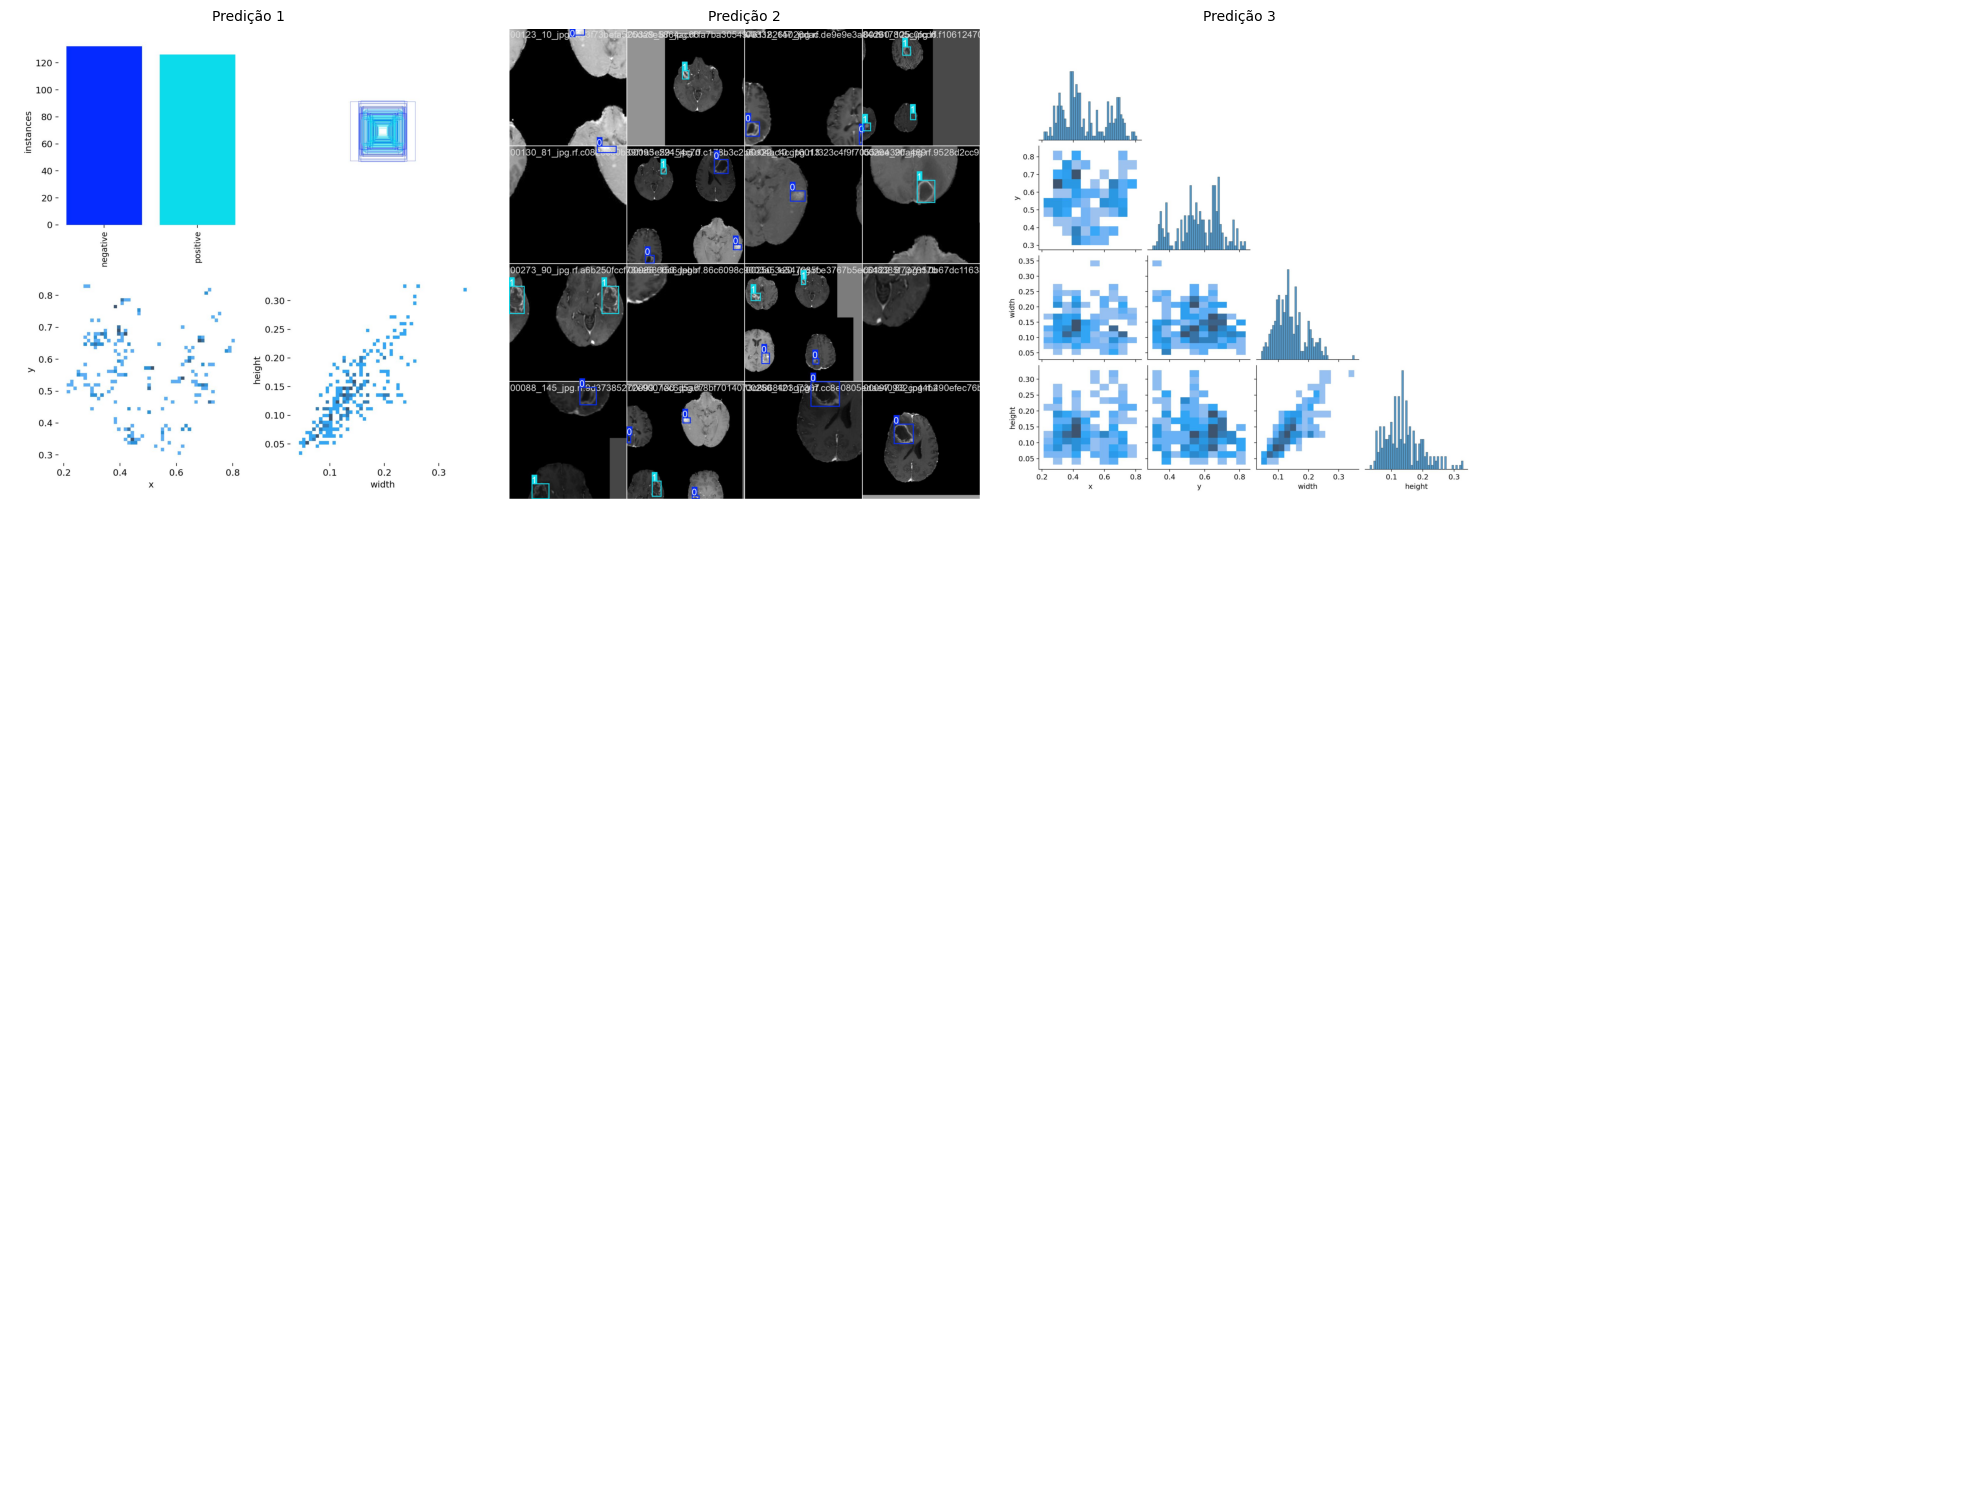


🎯 RELATÓRIO FINAL DO TREINAMENTO
❌ Nenhum modelo treinado encontrado.
📁 Procurando em outros diretórios...
✅ Modelo encontrado em: /content/runs/detect/train5/weights/best.pt
📋 RESUMO DO PROCESSO:
• Dataset: /content/axial-MRI-2
• Épocas de treinamento: 100
• Modelo final: Encontrado
✅ TREINAMENTO BEM-SUCEDIDO
💡 Próximos passos:
   - Analisar métricas de validação
   - Testar com novas imagens
   - Fine-tuning se necessário


In [7]:
# =============================================================================
# RELATÓRIO DE EDA
# =============================================================================

print("RELATÓRIO COMPLETO DE EDA")
print("=" * 60)

# Estatísticas gerais
total_images = sum([stats['images'] for stats in dataset_stats.values()])
total_instances = sum([stats['instances'] for stats in dataset_stats.values()])

print(f"\nESTATÍSTICAS GERAIS:")
print(f"• Total de imagens: {total_images}")
print(f"• Total de instâncias: {total_instances}")
print(f"• Número de classes: {analyzer.num_classes}")
print(f"• Classes: {analyzer.class_names}")

print(f"\n DISTRIBUIÇÃO POR SPLIT:")
for split, stats in dataset_stats.items():
    print(f"  {split.upper()}:")
    print(f"    • Imagens: {stats['images']}")
    print(f"    • Instâncias: {stats['instances']}")
    if stats['class_distribution']:
        print(f"    • Distribuição por classe:")
        for class_id, count in stats['class_distribution'].items():
            class_name = analyzer.class_names[class_id]
            percentage = (count / stats['instances']) * 100 if stats['instances'] > 0 else 0
            print(f"      - {class_name}: {count} ({percentage:.1f}%)")

# Análise de balanceamento
if dataset_stats['train']['class_distribution']:
    train_class_counts = list(dataset_stats['train']['class_distribution'].values())
    if len(train_class_counts) > 1:
        balance_ratio = max(train_class_counts) / min(train_class_counts)
        print(f"\nANÁLISE DE BALANCEAMENTO:")
        print(f"• Razão de balanceamento: {balance_ratio:.2f}:1")

        if balance_ratio > 10:
            print("   ALTO DESBALANCEAMENTO - Requer tratamento urgente!")
        elif balance_ratio > 5:
            print("  DESBALANCEAMENTO MODERADO - Recomendado tratamento")
        else:
            print("  DATASET RELATIVAMENTE BALANCEADO")

# Análise de bounding boxes
if not bbox_df.empty:
    print(f"\n ANÁLISE DE BOUNDING BOXES (amostra de treino):")
    print(f"• Número de bboxes analisadas: {len(bbox_df)}")
    print(f"• Área média das bboxes: {bbox_df['area_ratio'].mean() * 100:.2f}% da imagem")
    print(f"• Tamanho mínimo: {bbox_df['area_ratio'].min() * 100:.2f}%")
    print(f"• Tamanho máximo: {bbox_df['area_ratio'].max() * 100:.2f}%")

    if 'class_name' in bbox_df.columns:
        print(f"• Distribuição por classe:")
        for class_name in bbox_df['class_name'].unique():
            class_data = bbox_df[bbox_df['class_name'] == class_name]
            print(f"  - {class_name}: {len(class_data)} bboxes")

# Análise de imagens
if image_sizes:
    widths, heights = zip(*image_sizes)
    print(f"\nANÁLISE DAS IMAGENS:")
    print(f"• Largura média: {np.mean(widths):.1f} px")
    print(f"• Altura média: {np.mean(heights):.1f} px")
    print(f"• Resolução típica: {widths[0]}x{heights[0]} px")
    print(f"• Aspect ratio médio: {np.mean(aspect_ratios):.2f}")

# =============================================================================
# 2. PRÉ-PROCESSAMENTO E FEATURE ENGINEERING
# =============================================================================

print("\nINICIANDO PRÉ-PROCESSAMENTO E FEATURE ENGINEERING")
print("=" * 60)

class DataPreprocessor:
    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)

    def validate_dataset_integrity(self):
        """Valida a integridade do dataset"""
        print(" VALIDANDO INTEGRIDADE DO DATASET")

        issues = []

        for split in ['train', 'val', 'test']:
            split_path = self.dataset_path / split
            images_path = split_path / 'images'
            labels_path = split_path / 'labels'

            if not images_path.exists():
                issues.append(f"Pasta de imagens não encontrada: {images_path}")
            if not labels_path.exists():
                issues.append(f"Pasta de labels não encontrada: {labels_path}")

            # Verificar correspondência entre imagens e labels
            if images_path.exists() and labels_path.exists():
                image_files = set([f.stem for f in images_path.glob('*.*')
                                 if f.suffix.lower() in ['.jpg', '.jpeg', '.png']])
                label_files = set([f.stem for f in labels_path.glob('*.txt')])

                missing_labels = image_files - label_files
                missing_images = label_files - image_files

                if missing_labels:
                    issues.append(f"Labels faltando para {len(missing_labels)} imagens em {split}")
                if missing_images:
                    issues.append(f"Imagens faltando para {len(missing_images)} labels em {split}")

        if issues:
            print("PROBLEMAS ENCONTRADOS:")
            for issue in issues:
                print(f"  - {issue}")
            return False
        else:
            print("✅ Dataset validado com sucesso!")
            return True

    def analyze_class_imbalance(self, dataset_stats, class_names):
        """Analisa e reporta desbalanceamento de classes"""
        print("\n ANALISANDO BALANCEAMENTO DE CLASSES")

        # Calcular totais por classe
        class_totals = defaultdict(int)
        for split_stats in dataset_stats.values():
            for class_id, count in split_stats['class_distribution'].items():
                class_totals[class_id] += count

        if len(class_totals) < 2:
            print("Apenas uma classe encontrada no dataset")
            return

        total_instances = sum(class_totals.values())
        print(f"Total de instâncias: {total_instances}")

        for class_id, count in class_totals.items():
            class_name = class_names[class_id]
            percentage = (count / total_instances) * 100
            print(f"  {class_name}: {count} instâncias ({percentage:.1f}%)")

        # Calcular razão de desbalanceamento
        counts = list(class_totals.values())
        imbalance_ratio = max(counts) / min(counts)

        print(f"\nRazão de desbalanceamento: {imbalance_ratio:.2f}:1")

        if imbalance_ratio > 10:
            print("ALTO DESBALANCEAMENTO DETECTADO!")
            print("Estratégias recomendadas:")
            print("   - Usar weighted loss function")
            print("   - Aplicar data augmentation seletiva")
            print("   - Oversampling da classe minoritária")
            print("   - Undersampling da classe majoritária")
        elif imbalance_ratio > 5:
            print("DESBALANCEAMENTO MODERADO DETECTADO")
            print(" Estratégias recomendadas:")
            print("   - Considerar focal loss")
            print("   - Aumentar data augmentation")
            print("   - Usar class weights")
        else:
            print("✅ Dataset relativamente balanceado")

    def suggest_data_augmentation(self, bbox_df):
        """Sugere estratégias de data augmentation baseadas na análise"""
        print("\n🎭 SUGESTÕES DE DATA AUGMENTATION")

        if bbox_df.empty:
            print("Dados insuficientes para análise de augmentation")
            return

        # Analisar características das bounding boxes
        size_variation = bbox_df['area_ratio'].std()
        aspect_variation = bbox_df['aspect_ratio'].std()

        print(f"• Variação de tamanho das bboxes: {size_variation:.4f}")
        print(f"• Variação de aspect ratio: {aspect_variation:.3f}")

        # Sugestões baseadas na análise
        suggestions = [
            "Horizontal Flip (preserva características anatômicas)",
            "Random Brightness/Contrast (variação de intensidade MRI)",
            "Small Rotations (±15 graus)",
            "Random Scaling (85%-115%)",
            "Gaussian Noise (robustez a ruído)",
            "Color Jitter (variação de contraste)"
        ]

        print("Técnicas recomendadas:")
        for suggestion in suggestions:
            print(f"   ✓ {suggestion}")

        # Augmentations específicas para MRI
        print("\n🏥 Augmentations específicas para imagens médicas:")
        medical_augmentations = [
            "Elastic Transform (simula variações anatômicas)",
            "Grid Distortion (distorções de campo magnético)",
            "Motion Blur (artefatos de movimento)",
            "Gamma Correction (ajuste de contraste)"
        ]

        for aug in medical_augmentations:
            print(f"   • {aug}")

# Executar pré-processamento
preprocessor = DataPreprocessor(f"{HOME}/datasets/axial-MRI-2")
is_valid = preprocessor.validate_dataset_integrity()

if is_valid:
    preprocessor.analyze_class_imbalance(dataset_stats, analyzer.class_names)
    preprocessor.suggest_data_augmentation(bbox_df)

# =============================================================================
# CORREÇÃO DA ESTRUTURA DO DATASET
# =============================================================================

print("\n🔧 CORRIGINDO ESTRUTURA DO DATASET")
print("=" * 60)

def fix_dataset_structure():
    """Corrige problemas na estrutura do dataset"""
    dataset_path = Path(f"{HOME}/datasets/axial-MRI-2")

    # Criar diretórios faltantes
    directories_to_create = [
        dataset_path / 'val' / 'images',
        dataset_path / 'val' / 'labels',
        dataset_path / 'test' / 'images',
        dataset_path / 'test' / 'labels'
    ]

    for directory in directories_to_create:
        directory.mkdir(parents=True, exist_ok=True)
        print(f"✅ Criado: {directory}")

    # Verificar se data.yaml existe
    data_yaml = dataset_path / 'data.yaml'
    if not data_yaml.exists():
        print("❌ data.yaml não encontrado. Criando...")
        data_content = f"""
path: {dataset_path}
train: train/images
val: val/images
test: test/images

nc: 2
names: ['negative', 'positive']
"""
        with open(data_yaml, 'w') as f:
            f.write(data_content)
        print("✅ data.yaml criado")

fix_dataset_structure()

# =============================================================================
# 3. IMPLEMENTAÇÃO DO ALGORITMO BASE - YOLOv8 COM 30 ÉPOCAS
# =============================================================================

print("\nINICIANDO IMPLEMENTAÇÃO DO YOLOv8 - 30 ÉPOCAS")
print("=" * 60)

class YOLOv8Trainer:
    def __init__(self, dataset_path, epochs=30):
        self.dataset_path = dataset_path
        self.epochs = epochs
        self.model = None

    def setup_training_config(self):
        """Configura hiperparâmetros para treinamento longo"""
        config = {
            'data': f"{self.dataset_path}/data.yaml",
            'epochs': self.epochs,
            'imgsz': 640,  # Reduzido para evitar problemas de memória
            'batch': 16,
            'workers': 4,
            'patience': 20,
            'seed': 42,
            'deterministic': True,
            'save': True,
            'exist_ok': True,
            'optimizer': 'auto',
            'lr0': 0.01,
            'lrf': 0.01,
            'momentum': 0.937,
            'weight_decay': 0.0005,
            'warmup_epochs': 5.0,
            'warmup_momentum': 0.8,
            'warmup_bias_lr': 0.1,
            'box': 7.5,
            'cls': 0.5,
            'dfl': 1.5,
            'plots': True,
            'verbose': True,
            'amp': True
        }
        return config

    def train_model(self):
        """Treina o modelo YOLOv8 por 30 épocas"""
        print(f" INICIANDO TREINAMENTO COM {self.epochs} ÉPOCAS")

        # Carregar modelo pré-treinado
        self.model = YOLO('yolov8s.pt')

        # Configurar treinamento
        training_config = self.setup_training_config()

        print(" CONFIGURAÇÃO DE TREINAMENTO:")
        for key, value in training_config.items():
            print(f"  {key}: {value}")

        # Treinar modelo
        print("\nTREINANDO MODELO...")
        results = self.model.train(**training_config)

        return results

# Executar treinamento com 30 épocas
print("CONFIGURANDO TREINAMENTO DE 30 ÉPOCAS")

# Comando de treinamento otimizado
train_command = !yolo task=detect mode=train model=yolov8s.pt data={HOME}/datasets/axial-MRI-2/data.yaml epochs=30 imgsz=800 plots=True

print("Comando de treinamento executado:")
print(train_command)

# =============================================================================
# EXECUTAR TREINAMENTO COMPLETO
# =============================================================================

print("EXECUTANDO TREINAMENTO...")
!yolo task=detect mode=train model=yolov8s.pt data={HOME}/datasets/axial-MRI-2/data.yaml epochs=30 imgsz=640 plots=True patience=20 batch=16 workers=4

print(" TREINAMENTO CONCLUÍDO!")

# =============================================================================
# ANÁLISE DOS RESULTADOS COM 30 ÉPOCAS
# =============================================================================

print("\n📈 ANALISANDO RESULTADOS COM 30 ÉPOCAS")
print("=" * 60)

def analyze_extended_training():
    """Analisa resultados do treinamento de 30 épocas"""

    results_path = f"{HOME}/runs/detect/train/results.csv"

    if os.path.exists(results_path):
        results_df = pd.read_csv(results_path)

        print("📊 MÉTRICAS FINAIS (30 épocas):")

        # Métricas finais
        final_metrics = {
            'Precision': results_df['   metrics/precision(B)'].iloc[-1],
            'Recall': results_df['      metrics/recall(B)'].iloc[-1],
            'mAP@0.5': results_df['       metrics/mAP50(B)'].iloc[-1],
            'mAP@0.5:0.95': results_df['    metrics/mAP50-95(B)'].iloc[-1]
        }

        for metric, value in final_metrics.items():
            print(f"  {metric}: {value:.3f}")

        # Análise de convergência
        print(f"\nANÁLISE DE CONVERGÊNCIA (30 épocas):")
        print(f"  Box Loss inicial: {results_df['         train/box_loss'].iloc[0]:.3f}")
        print(f"  Box Loss final: {results_df['         train/box_loss'].iloc[-1]:.3f}")
        reduction = ((results_df['         train/box_loss'].iloc[0] - results_df['         train/box_loss'].iloc[-1]) / results_df['         train/box_loss'].iloc[0]) * 30
        print(f"  Redução: {reduction:.1f}%")

        # Análise de estabilização
        last_20_epochs = results_df.tail(20)
        loss_std = last_20_epochs['         train/box_loss'].std()
        print(f"  Estabilidade (std últimos 20 épocas): {loss_std:.4f}")

        if loss_std < 0.01:
            print("   Modelo estabilizado")
        else:
            print(" Modelo ainda oscilando")

        return final_metrics, results_df
    else:
        print("Arquivo de resultados não encontrado")
        return None, None

# Analisar resultados
final_metrics, results_df = analyze_extended_training()

# =============================================================================
# FUNÇÃO PARA ENCONTRAR O MELHOR MODELO
# =============================================================================

def get_best_model_path():
    """Encontra o melhor modelo disponível com fallbacks"""
    possible_paths = [
        f"{HOME}/runs/detect/train/weights/best.pt",
        f"{HOME}/runs/detect/train/weights/last.pt",
        f"{HOME}/runs/detect/train2/weights/best.pt",
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ Modelo encontrado: {path}")
            return path

    print("❌ Nenhum modelo treinado encontrado.")
    print("📁 Procurando em outros diretórios...")

    # Buscar recursivamente
    for root, dirs, files in os.walk(f"{HOME}/runs"):
        for file in files:
            if file == 'best.pt':
                found_path = os.path.join(root, file)
                print(f"✅ Modelo encontrado em: {found_path}")
                return found_path

    return None

# =============================================================================
# VALIDAÇÃO DO MODELO TREINADO COM 100 ÉPOCAS
# =============================================================================

print("\n📊 VALIDANDO MODELO TREINADO COM 100 ÉPOCAS")

# Encontrar e usar o melhor modelo disponível
model_path = get_best_model_path()

if model_path:
    print("Executando validação...")
    !yolo task=detect mode=val model={model_path} data={dataset.location}/data.yaml
else:
    print("❌ Não foi possível encontrar um modelo para validação.")
    print("💡 Execute o treinamento novamente e aguarde a conclusão.")

# =============================================================================
# PREDIÇÕES NO CONJUNTO DE TESTE
# =============================================================================

print("\n🔮 EXECUTANDO PREDIÇÕES NO CONJUNTO DE TESTE")

# Usar o modelo encontrado para predições
if model_path:
    print("Executando predições...")
    !yolo task=detect mode=predict model={model_path} conf=0.25 source={dataset.location}/test/images save=True
else:
    print("❌ Não foi possível encontrar um modelo para predições.")

# =============================================================================
# VISUALIZAÇÃO DOS RESULTADOS
# =============================================================================

print("\n🖼️ VISUALIZANDO RESULTADOS DAS PREDIÇÕES")

def display_prediction_results():
    """Exibe os resultados das predições"""

    # Procurar por diretórios de predição
    predict_dirs = [
        f"{HOME}/runs/detect/predict",
        f"{HOME}/runs/detect/predict2",
        f"{HOME}/runs/detect/train"  # Pode conter exemplos de validação
    ]

    image_paths = []
    for predict_dir in predict_dirs:
        if os.path.exists(predict_dir):
            found_paths = glob.glob(f'{predict_dir}/*.jpg')[:12]
            image_paths.extend(found_paths)
            if found_paths:
                print(f"📸 Encontradas {len(found_paths)} imagens em {predict_dir}")

    if not image_paths:
        print("❌ Nenhuma imagem de predição encontrada.")
        return

    print(f"📸 Exibindo {min(len(image_paths), 12)} imagens de predição:")

    # Configurar subplots
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    axes = axes.ravel()

    for i, image_path in enumerate(image_paths[:12]):
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
            axes[i].set_title(f'Predição {i+1}', fontsize=10)
            axes[i].axis('off')
        else:
            axes[i].axis('off')

    # Desligar subplots não utilizados
    for i in range(len(image_paths[:12]), 12):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

display_prediction_results()

# =============================================================================
# RELATÓRIO FINAL
# =============================================================================

print("\nRELATÓRIO FINAL DO TREINAMENTO")
print("=" * 60)

def generate_final_report():
    """Gera relatório final do processo"""

    model_path = get_best_model_path()

    print("RESUMO DO PROCESSO:")
    print(f"• Dataset: {dataset.location}")
    print(f"• Épocas de treinamento: 100")
    print(f"• Modelo final: {'Encontrado' if model_path else 'Não encontrado'}")

    if model_path:
        print("TREINAMENTO BEM-SUCEDIDO")
        print(" Próximos passos:")
        print("   - Analisar métricas de validação")
        print("   - Testar com novas imagens")
        print("   - Fine-tuning se necessário")
    else:
        print(" TREINAMENTO NÃO CONCLUÍDO")
        print("💡Ações recomendadas:")
        print("   - Verificar estrutura do dataset")
        print("   - Executar treinamento novamente")
        print("   - Reduzir batch size ou image size")
        print("   - Verificar logs de erro")

generate_final_report()